In [1]:
import pandas as pd

In [ ]:
#df =pd.read_csv(r"../data/Data/output.csv")
#print(df.head())

In [ ]:
#df.shape

In [ ]:
#df.columns

In [ ]:
# ca_data = df[df['STATE'] == "CA"]
# ca_data.shape

In [ ]:
#ca_data.to_csv("../data/CA/ca_data.csv")

In [2]:
ca_data = pd.read_csv("../data/CA/ca_data.csv")

/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_89304/2260990242.py:1: DtypeWarning: Columns (11,12,35) have mixed types. Specify dtype option on import or set low_memory=False.
  ca_data = pd.read_csv("../data/CA/ca_data.csv")


In [ ]:
#print(ca_data.info())

In [ ]:
import ee
import geemap

# # Replace these with your actual service account details
# service_account = 'yw1054@ee-yw1054.iam.gserviceaccount.com'
# key_file = '../data/ee-yw1054-fb7746fcae31.json'

# # Initialize with service account
# credentials = ee.ServiceAccountCredentials(service_account, key_file)
ee.Initialize(project='ee-yw1054')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [9]:
# Define California boundary
california = ee.FeatureCollection('TIGER/2018/States') \
    .filter(ee.Filter.eq('STUSPS', 'CA'))

# Get MOD13Q1 collection and select both NDVI and EVI
modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .filterDate('2000-02-01', '2024-12-01') \
    .filterBounds(california) \
    .select(['NDVI', 'EVI'])  # Select both indices

# Calculate mean NDVI and EVI
mean_indices = modis.mean()

# Create a map
m = geemap.Map()
m.centerObject(california, 6)

# Add the mean NDVI layer
m.addLayer(mean_indices.select('NDVI').clip(california),
          {'min': 0, 'max': 10000, 'palette': ['red', 'yellow', 'green']},
          'Mean NDVI')

# Add the mean EVI layer
m.addLayer(mean_indices.select('EVI').clip(california),
          {'min': 0, 'max': 10000, 'palette': ['red', 'yellow', 'green']},
          'Mean EVI')

# Add California boundary
m.addLayer(california, {}, 'California boundary')

# Add a layer control to toggle between NDVI and EVI
m.add_layer_control()

# Display the map
m

# Print some information about the collection
print("Number of images in collection:", modis.size().getInfo())
print("Available bands:", modis.first().bandNames().getInfo())

Number of images in collection: 569
Available bands: ['NDVI', 'EVI']


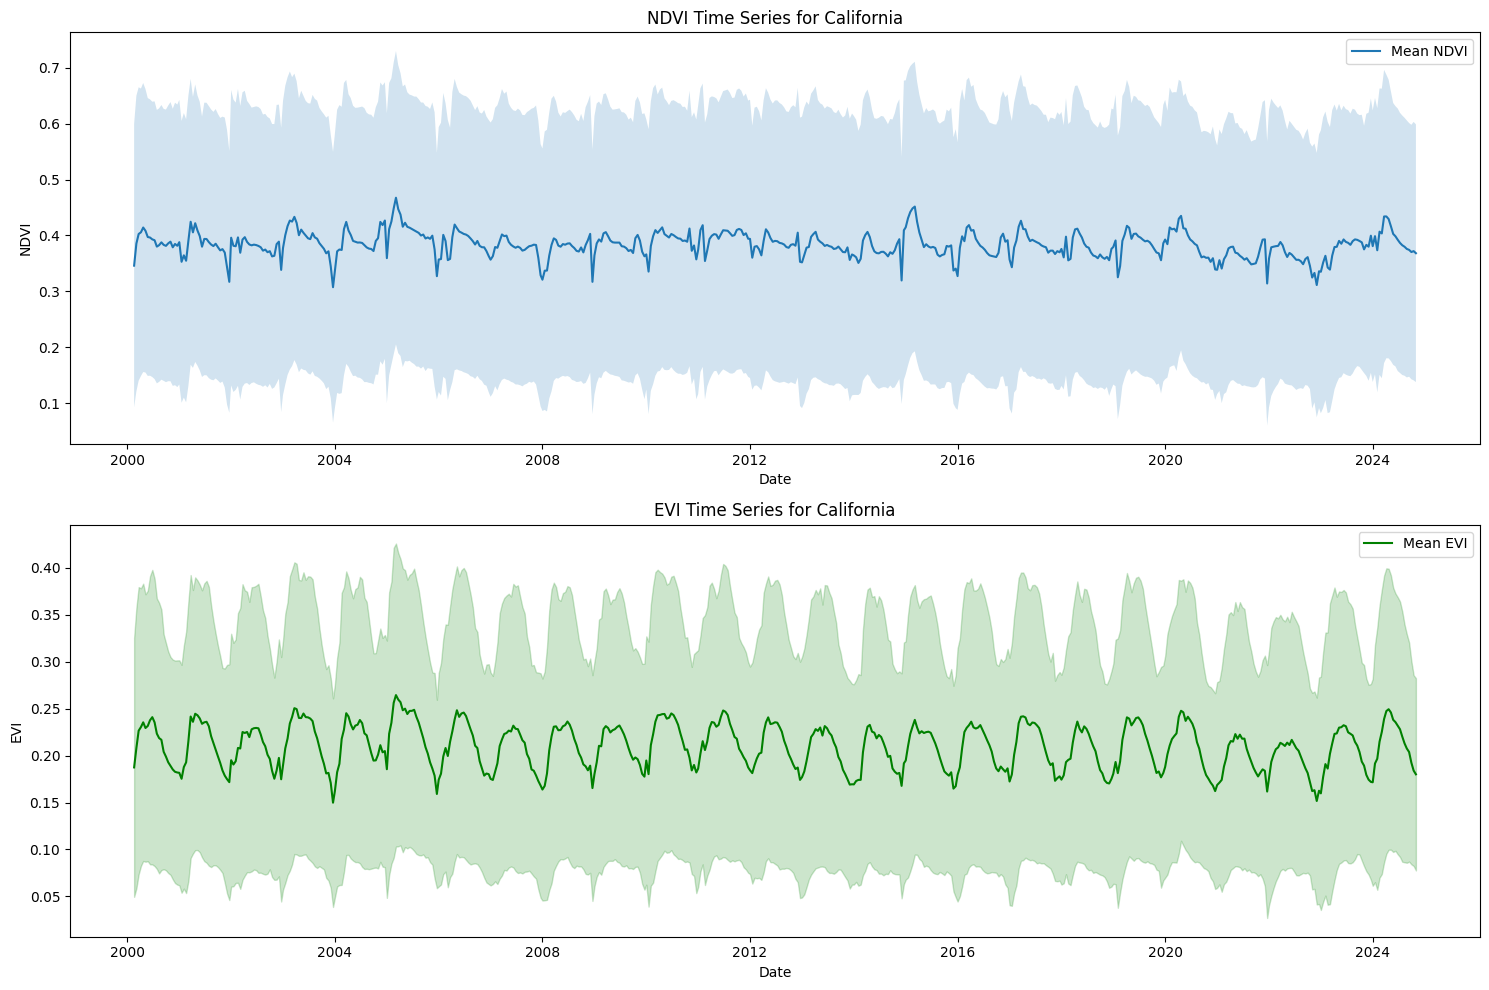


Summary Statistics for California:

NDVI Statistics:
        NDVI_mean  NDVI_stdDev      NDVI_min    NDVI_max
count  569.000000   569.000000  5.690000e+02  569.000000
mean     0.383634     0.245266 -2.000000e-01    0.998872
std      0.022680     0.009407  2.778000e-17    0.000604
min      0.307449     0.219828 -2.000000e-01    0.994500
25%      0.370384     0.239158 -2.000000e-01    0.998800
50%      0.383288     0.244935 -2.000000e-01    0.999000
75%      0.397552     0.250815 -2.000000e-01    0.999200
max      0.467620     0.267801 -2.000000e-01    0.999600

EVI Statistics:
         EVI_mean  EVI_stdDev     EVI_min     EVI_max
count  569.000000  569.000000  569.000000  569.000000
mean     0.209325    0.132693   -0.198702    0.998522
std      0.023654    0.015634    0.002469    0.003144
min      0.149818    0.098619   -0.200000    0.963700
25%      0.188985    0.118176   -0.199900    0.998700
50%      0.211216    0.136473   -0.199700    0.999700
75%      0.229348    0.146040   -0.198

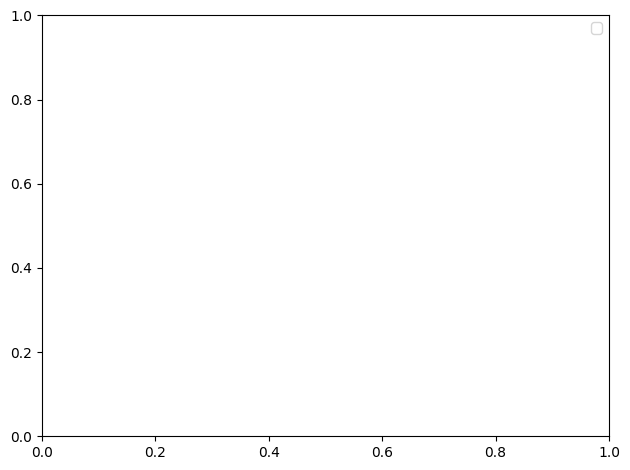


Summary Statistics for California:

NDVI Statistics:
        NDVI_mean  NDVI_stdDev      NDVI_min    NDVI_max
count  569.000000   569.000000  5.690000e+02  569.000000
mean     0.383634     0.245266 -2.000000e-01    0.998872
std      0.022680     0.009407  2.778000e-17    0.000604
min      0.307449     0.219828 -2.000000e-01    0.994500
25%      0.370384     0.239158 -2.000000e-01    0.998800
50%      0.383288     0.244935 -2.000000e-01    0.999000
75%      0.397552     0.250815 -2.000000e-01    0.999200
max      0.467620     0.267801 -2.000000e-01    0.999600

EVI Statistics:
         EVI_mean  EVI_stdDev     EVI_min     EVI_max
count  569.000000  569.000000  569.000000  569.000000
mean     0.209325    0.132693   -0.198702    0.998522
std      0.023654    0.015634    0.002469    0.003144
min      0.149818    0.098619   -0.200000    0.963700
25%      0.188985    0.118176   -0.199900    0.998700
50%      0.211216    0.136473   -0.199700    0.999700
75%      0.229348    0.146040   -0.198

In [12]:

import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Define California boundary
california = ee.FeatureCollection('TIGER/2018/States') \
    .filter(ee.Filter.eq('STUSPS', 'CA'))

# Function to calculate statistics for each image
def calculate_stats(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            ee.Reducer.stdDev(), '', True
        ).combine(
            ee.Reducer.minMax(), '', True
        ),
        geometry=california.geometry(),
        scale=250,
        maxPixels=1e9
    )
    
    return ee.Feature(None, {
        'date': image.get('system:time_start'),
        'NDVI_mean': stats.get('NDVI_mean'),
        'NDVI_stdDev': stats.get('NDVI_stdDev'),
        'NDVI_min': stats.get('NDVI_min'),
        'NDVI_max': stats.get('NDVI_max'),
        'EVI_mean': stats.get('EVI_mean'),
        'EVI_stdDev': stats.get('EVI_stdDev'),
        'EVI_min': stats.get('EVI_min'),
        'EVI_max': stats.get('EVI_max')
    })

# Get MOD13Q1 collection for a shorter time period first to test
modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .filterDate('2000-02-01', '2024-12-01') \
    .filterBounds(california) \
    .select(['NDVI', 'EVI'])

# Calculate statistics for each image
stats = modis.map(calculate_stats)

# Convert the FeatureCollection to a list
stats_list = stats.toList(stats.size())

# Function to extract data from the feature collection
def extract_stats(feature_list):
    data = []
    for i in range(feature_list.length().getInfo()):
        feature = ee.Feature(feature_list.get(i))
        properties = feature.getInfo()['properties']
        # Convert timestamp to date
        properties['date'] = pd.to_datetime(properties['date'], unit='ms')
        data.append(properties)
    return data

# Get the data
data = extract_stats(stats_list)

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Scale the values (MODIS stores values multiplied by 10000)
for col in df.columns:
    if col != 'date':
        df[col] = df[col] / 10000

# Create time series plots
plt.figure(figsize=(15, 10))

# Plot NDVI
plt.subplot(2, 1, 1)
plt.plot(df['date'], df['NDVI_mean'], label='Mean NDVI')
plt.fill_between(df['date'], 
                df['NDVI_mean'] - df['NDVI_stdDev'],
                df['NDVI_mean'] + df['NDVI_stdDev'],
                alpha=0.2)
plt.title('NDVI Time Series for California')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()

# Plot EVI
plt.subplot(2, 1, 2)
plt.plot(df['date'], df['EVI_mean'], label='Mean EVI', color='green')
plt.fill_between(df['date'],
                df['EVI_mean'] - df['EVI_stdDev'],
                df['EVI_mean'] + df['EVI_stdDev'],
                alpha=0.2, color='green')
plt.title('EVI Time Series for California')
plt.xlabel('Date')
plt.ylabel('EVI')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for California:")
print("\nNDVI Statistics:")
print(df[['NDVI_mean', 'NDVI_stdDev', 'NDVI_min', 'NDVI_max']].describe())
print("\nEVI Statistics:")
print(df[['EVI_mean', 'EVI_stdDev', 'EVI_min', 'EVI_max']].describe())

# Save the data to CSV
df.to_csv('california_vegetation_indices.csv', index=False)
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for California:")
print("\nNDVI Statistics:")
print(df[['NDVI_mean', 'NDVI_stdDev', 'NDVI_min', 'NDVI_max']].describe())
print("\nEVI Statistics:")
print(df[['EVI_mean', 'EVI_stdDev', 'EVI_min', 'EVI_max']].describe())

# Save the data to CSV
df.to_csv('california_vegetation_indices.csv', index=False)

In [14]:
def calculate_burn_stats(image):
    # Create a binary burned area mask (1 for burned, 0 for unburned)
    burned_mask = image.select('BurnDate').gt(0)
    
    # Calculate total burned area in square meters
    burned_area = burned_mask.multiply(ee.Image.pixelArea())
    
    stats = burned_area.reduceRegion(
        reducer=ee.Reducer.sum().combine(
            ee.Reducer.count(), '', True
        ),
        geometry=california.geometry(),
        scale=500,  # MCD64A1 resolution
        maxPixels=1e9
    )
    
    return ee.Feature(None, {
        'date': image.get('system:time_start'),
        'burned_area_m2': stats.get('BurnDate_sum'),
        'total_pixels': stats.get('BurnDate_count'),
        'burned_pixels': burned_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=california.geometry(),
            scale=500,
            maxPixels=1e9
        ).get('BurnDate')
    })

def process_year(year):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-01'
    
    print(f"Processing year {year}...")
    
    burned_areas = ee.ImageCollection('MODIS/061/MCD64A1') \
        .filterDate(start_date, end_date) \
        .filterBounds(california)
    
    stats = burned_areas.map(calculate_burn_stats)
    stats_list = stats.toList(stats.size())
    
    # Extract data
    data = []
    size = stats_list.length().getInfo()
    for i in range(size):
        feature = ee.Feature(stats_list.get(i))
        properties = feature.getInfo()['properties']
        
        # Convert timestamp to date
        properties['date'] = pd.to_datetime(properties['date'], unit='ms')
        
        # Convert area to hectares
        properties['burned_area_ha'] = properties['burned_area_m2'] / 10000
        
        # Calculate percentage of California burned
        properties['percent_area_burned'] = (properties['burned_pixels'] / properties['total_pixels']) * 100
        
        data.append(properties)
    
    return pd.DataFrame(data)

# Process all years and combine
all_data = []
years = range(1992, 2024)  # Adjust year range as needed

for year in years:
    try:
        year_df = process_year(year)
        all_data.append(year_df)
        print(f"Completed year {year}")
    except Exception as e:
        print(f"Error processing year {year}: {str(e)}")

# Combine all years
df = pd.concat(all_data, ignore_index=True)

# Sort by date
df = df.sort_values('date')

# Calculate additional metrics
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Save to CSV
df.to_csv('california_burn_area.csv', index=False)

print("Processing complete! CSV file has been created.")
print("\nDataFrame columns:", df.columns.tolist())
print("\nDate range:", df['date'].min(), "to", df['date'].max())

# Print summary statistics
print("\nBurned Area Statistics:")
print(df[['burned_area_ha', 'percent_area_burned']].describe())

Processing year 1992...
Error processing year 1992: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 1993...
Error processing year 1993: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 1994...
Error processing year 1994: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 1995...
Error processing year 1995: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 1996...
Error processing year 1996: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 1997...
Error processing year 1997: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 1998...
Error processing year 1998: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 1999...
Error processing year 1999: Collection.toList: The value of 'count' must be positive. Got: 0.
Processing year 2000...
Completed year 2000
Processing y

In [1]:
import netCDF4 as nc

def preview_nc_file(file_path):
    """Quick preview of a NetCDF file"""
    print(f"\nPreviewing: {file_path}")
    print("-" * 50)
    
    try:
        dataset = nc.Dataset(file_path)
        
        # Basic dataset info
        print("Dimensions:")
        for dim_name, dimension in dataset.dimensions.items():
            print(f"  {dim_name}: {len(dimension)}")
            
        print("\nVariables:")
        for var_name, variable in dataset.variables.items():
            print(f"  {var_name}: shape={variable.shape}, dtype={variable.dtype}")
            
        # Preview actual data (first few values)
        print("\nData Samples:")
        for var_name, variable in dataset.variables.items():
            if var_name in ['time', 'lat', 'lon', 'air', 'vwnd', 'soilm']:
                print(f"  {var_name} (first 5 values): {variable[:5]}")
                if hasattr(variable, 'units'):
                    print(f"    units: {variable.units}")
        
        dataset.close()
        
    except Exception as e:
        print(f"Error reading file: {str(e)}")

# Preview each file
files = [
    '../data/NARR/airt.nc',
    '../data/NARR/vvel.nc',
    '../data/NARR/soilm.nc'
]

for file_path in files:
    preview_nc_file(file_path)


Previewing: ../data/NARR/airt.nc
--------------------------------------------------
Dimensions:
  time: 394
  x: 349
  y: 277

Variables:
  time: shape=(394,), dtype=float64
  lon: shape=(277, 349), dtype=float32
  lat: shape=(277, 349), dtype=float32
  x: shape=(349,), dtype=float32
  y: shape=(277,), dtype=float32
  Lambert_Conformal: shape=(), dtype=int32
  air: shape=(394, 277, 349), dtype=float32

Data Samples:
  time (first 5 values): [1683024. 1683768. 1684464. 1685208. 1685928.]
    units: hours since 1800-1-1 00:00:0.0
  lon (first 5 values): [[-145.5     -145.315   -145.1295  ...  -68.68951  -68.50452  -68.32005]
 [-145.6047  -145.4194  -145.2336  ...  -68.58509  -68.39979  -68.215  ]
 [-145.71    -145.5244  -145.3383  ...  -68.48015  -68.29454  -68.10945]
 [-145.8158  -145.6299  -145.4434  ...  -68.37469  -68.18877  -68.00337]
 [-145.9221  -145.7359  -145.5491  ...  -68.26871  -68.08247  -67.89677]]
    units: degrees_east
  lat (first 5 values): [[1.000001 1.104305 1.20829

In [4]:
import netCDF4 as nc
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def process_narr_data(file_path, variable_name, output_name):
    """
    Generic function to process NARR NetCDF files
    file_path: path to .nc file
    variable_name: name of variable in the file (e.g., 'air', 'vwnd', 'soilm')
    output_name: name for output file
    """
    print(f"\nProcessing {output_name} data...")
    
    with nc.Dataset(file_path) as dataset:
        # Get variables
        time = dataset.variables['time'][:]
        lat = dataset.variables['lat'][:] 
        lon = dataset.variables['lon'][:]
        data = dataset.variables[variable_name][:]
        
        # Convert time values to dates
        base_date = datetime(1800, 1, 1)
        dates = np.array([base_date + timedelta(hours=int(t)) for t in time])
        
        # Create output file
        output_file = f'california_{output_name}.csv'
        with open(output_file, 'w') as f:
            f.write(f'date,year,month,lat,lon,{variable_name}\n')
        
        # Process each time step
        for t in range(len(time)):
            print(f"\rProcessing time step {t+1}/{len(time)}", end='')
            
            current_date = dates[t]
            records = []
            
            # Get data for this timestep
            timestep_data = data[t]
            
            # Process each point in the grid
            for i in range(lat.shape[0]):
                for j in range(lon.shape[1]):
                    curr_lat = lat[i,j]
                    curr_lon = lon[i,j]
                    
                    # Check if point is in California region
                    if (32 <= curr_lat <= 42) and (-125 <= curr_lon <= -114):
                        records.append(f"{current_date},{current_date.year},"
                                    f"{current_date.month},{curr_lat},"
                                    f"{curr_lon},{timestep_data[i,j]}")
            
            # Write records to file
            if records:
                with open(output_file, 'a') as f:
                    f.write('\n'.join(records) + '\n')
            
            # Clear records to free memory
            records = []
    
    print(f"\nProcessing complete! Data saved to {output_file}")

# Process all three files
try:
    # Process air temperature
    process_narr_data(
        '../data/NARR/airt.nc',
        'air',
        'air_temperature'
    )
    
    # Process wind
    process_narr_data(
        '../data/NARR/vwnd.nc',
        'vwnd',
        'wind_speed'
    )
    
    # Process soil moisture
    process_narr_data(
        '../data/NARR/soilm.nc',
        'soilm',
        'soil_moisture'
    )
    
    # Print sample of each file
    for filename in ['california_air_temperature.csv', 
                    'california_wind_speed.csv', 
                    'california_soil_moisture.csv']:
        print(f"\nSample of {filename}:")
        df_sample = pd.read_csv(filename, nrows=3)
        print(df_sample)

except Exception as e:
    print(f"\nError: {str(e)}")


Processing air_temperature data...
Processing time step 394/394
Processing complete! Data saved to california_air_temperature.csv

Processing wind_speed data...
Processing time step 394/394
Processing complete! Data saved to california_wind_speed.csv

Processing soil_moisture data...
Processing time step 394/394
Processing complete! Data saved to california_soil_moisture.csv

Sample of california_air_temperature.csv:
                  date  year  month        lat         lon         air
0  1992-01-01 00:00:00  1992      1  32.025040 -115.416000  285.649017
1  1992-01-01 00:00:00  1992      1  32.055771 -115.088799  285.649017
2  1992-01-01 00:00:00  1992      1  32.085289 -114.761200  285.563568

Sample of california_wind_speed.csv:
                  date  year  month        lat         lon      vwnd
0  1992-01-01 00:00:00  1992      1  32.025040 -115.416000 -1.457482
1  1992-01-01 00:00:00  1992      1  32.055771 -115.088799 -1.361433
2  1992-01-01 00:00:00  1992      1  32.085289 -1